### Loading libraries

In [1]:
%pip install pandas scikit-learn nltk plotly numpy seaborn


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


In [3]:
import plotly.express as px


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/grandhi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/grandhi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
# Load data
data = pd.read_csv(
    "./data/nlp-getting-started/train.csv",)

# Encoding target variable
#data["target"] = np.where(data["target"] == "spam", 1, 0)

In [6]:
data.sample(10)

,id,keyword,location,text,target
3912,5563,flood,United States,JKL cancels Flash Flood Warning for Bell Harla...,1
1080,1560,bomb,lagos nigeria,If I fall is men GOD @Praiz8 is d bomb well av...,1
1895,2726,crushed,online,WRAPUP 2-U.S. cable TV companies' shares crush...,0
2923,4202,drowned,"R'lyeh, South Pacific",Sadly before she could save humanity Ursula dr...,1
2238,3198,deluge,NaN,#MeditationByMSG 45600 ppl got method of medit...,0
6653,9533,terrorist,????? ???? ????,#UdhampurAgain 2 terrorist shot dead.. #Udhampur,1
7553,10798,wrecked,NaN,#news Cramer: Iger's 3 words that wrecked Disn...,0
184,263,ambulance,"Swindon,England",@TanSlash waiting for an ambulance,0
734,1062,bleeding,NaN,Deadpool is already one of my favourite marvel...,0
6979,10010,twister,NaN,Want Twister Tickets AND A CHANCE AT A VIP EXP...,0


In [7]:
df = data.copy()
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
df.sample(10)

,id,keyword,location,text,target
3602,5142,fatal,??? ???? ??????,Investigators shift focus to cause of fatal Wa...,1
5601,7991,razed,Nairobi-KENYA,George Njenga the hero saved his burning frien...,1
4711,6699,lava,"Pocatello, Idaho",Perfect night for a soak! Lava here I come?? h...,0
1805,2593,crash,"Lancaster, Pennsylvania, USA",Police respond to crash find 'suspected heroin...,1
6597,9449,terrorism,NaN,Truth...\nhttps://t.co/nXS3Z1kxiD\n#News\n#BBC...,1
1959,2821,cyclone,Philippines,SEVERE WEATHER BULLETIN No. 5\nFOR: TYPHOON Û...,1
6178,8812,sirens,they/them,'I know a dill pickle when I taste one' -me,0
4040,5739,forest%20fires,NaN,#NaturalDisasters As California fires rage the...,1
868,1253,blood,International,If it wasn't for the Blood! ????,0
7545,10786,wrecked,Robin Hood's County,late night mcdonalds with friends = hilarious ...,0


In [9]:
df['target'] = df['target'].astype('category')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        7613 non-null   int64   
 1   keyword   7552 non-null   object  
 2   location  5080 non-null   object  
 3   text      7613 non-null   object  
 4   target    7613 non-null   category
dtypes: category(1), int64(1), object(3)
memory usage: 245.6+ KB


In [11]:
df.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

In [12]:
df['target'].value_counts()


0    4342
1    3271
Name: target, dtype: int64

Text(0.5, 1.0, 'General tweets and disaster tweets')

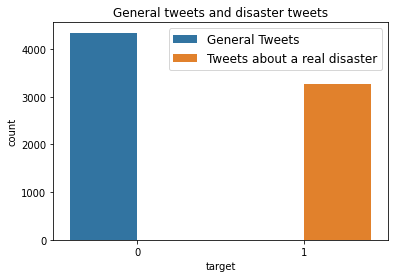

In [13]:
sns.countplot(data=df, x='target', hue='target' )
plt.legend(labels=["General Tweets","Tweets about a real disaster"],
           fontsize = 'large', title_fontsize = "10")
plt.title('General tweets and disaster tweets')

In [14]:
#df1 = df.groupby('keyword').size()
df1 = pd.crosstab(df.keyword,df.target).reset_index()
df1.rename(columns={0:'general',1:'disaster'},inplace=True)
df1.eval('total = general + disaster',inplace=True)
df1.sort_values(by='total',ascending=False,inplace=True)
df1 = df1.head(20)
df1

target,keyword,general,disaster,total
104,fatalities,19,26,45
63,deluge,36,6,42
8,armageddon,37,5,42
177,sinking,33,8,41
57,damage,22,19,41
119,harm,37,4,41
29,body%20bags,40,1,41
153,outbreak,1,39,40
95,evacuate,15,25,40
106,fear,35,5,40


In [15]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x = df1.keyword,
    y=df1.general,
    name= 'General Tweets'
    
   
))
fig.add_trace(go.Bar(
    x = df1.keyword,
    y=df1.disaster,
    name = 'Disaster Tweets' ,
    marker_color='indianred'
))


fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                    title = 'Top 20 keywords used in the Tweets',
                    xaxis_title = 'keywords used in Tweets',
                    yaxis_title = 'counts',legend=dict(
                    yanchor="top",y=0.99,xanchor="left",x=0.80)
                    )
fig.show()


In [16]:
px.bar(df1, y= 'total' , x='keyword')

In [17]:
#filling null values with some number

df['keyword'].fillna('10', inplace=True)
df['location'].fillna('10',inplace=True)

In [18]:
# converting to strings

df['keyword'] = df['keyword'].astype('str')
df['location'] = df['location'].astype('str')


In [29]:
# adding all the columns

df.eval('w_text = keyword+text',inplace=True)
df['w_text'] = df['w_text'].astype('str')

df.head()

,id,keyword,location,text,target,w_text,text_fin
0,1,10,10,Our Deeds are the Reason of this #earthquake M...,1,10Our Deeds are the Reason of this #earthquake...,our deeds are the reason of this earthqua...
1,4,10,10,Forest fire near La Ronge Sask. Canada,1,10Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,5,10,10,All residents asked to 'shelter in place' are ...,1,10All residents asked to 'shelter in place' ar...,all residents asked to shelter in place ...
3,6,10,10,"13,000 people receive #wildfires evacuation or...",1,"1013,000 people receive #wildfires evacuation ...",people receive wildfires evacuatio...
4,7,10,10,Just got sent this photo from Ruby #Alaska as ...,1,10Just got sent this photo from Ruby #Alaska a...,just got sent this photo from ruby alaska...


In [30]:
### remove special characters

import re
corpus = []
for i in range(len(df['w_text'])):
    review = re.sub('[^a-zA-Z]', ' ', df['w_text'][i])
    review = review.lower()
    corpus.append(review)

df['text_fin'] = np.array(corpus)


In [31]:
df.sample(5)

,id,keyword,location,text,target,w_text,text_fin
525,759,avalanche,UK,Musician Kalle Mattson Recreates 34 Classic Al...,0,avalancheMusician Kalle Mattson Recreates 34 C...,avalanchemusician kalle mattson recreates c...
7341,10511,wildfire,USA,The Latest: Washington #Wildfire misses town; ...,1,wildfireThe Latest: Washington #Wildfire misse...,wildfirethe latest washington wildfire misse...
2320,3336,demolished,"Dublin, Ireland",Home2 Suites offices are coming to Salvi's Bis...,0,demolishedHome2 Suites offices are coming to S...,demolishedhome suites offices are coming to s...
4172,5927,harm,10,@news4buffalo yes a lot more harm then good if...,0,harm@news4buffalo yes a lot more harm then goo...,harm news buffalo yes a lot more harm then goo...
1532,2214,chemical%20emergency,London,.@david_cameron Stop upsetting this bee! Liste...,0,chemical%20emergency.@david_cameron Stop upset...,chemical emergency david cameron stop upset...


In [32]:
# Split dataset between train and test sets
X_train, X_test, y_train, y_test = train_test_split(df["text_fin"], df["target"], random_state=0)

#### Using TF-IDF

In [33]:
# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 15
# This means a word should have been used in at least 15 SMS 
vect = TfidfVectorizer(min_df=5).fit(X_train)

# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)

# let's look of some of the words gathered with this method
sorted(vect.vocabulary_.items(), key=lambda x: x[1])[10:30]

[('ac', 10),
 ('accident', 11),
 ('accidentexperts', 12),
 ('accidenti', 13),
 ('accidents', 14),
 ('according', 15),
 ('account', 16),
 ('across', 17),
 ('act', 18),
 ('action', 19),
 ('actions', 20),
 ('active', 21),
 ('activity', 22),
 ('actually', 23),
 ('added', 24),
 ('address', 25),
 ('advance', 26),
 ('af', 27),
 ('affected', 28),
 ('africa', 29)]

In [34]:
# how many words appear in more than 15 text messages
len(sorted(vect.vocabulary_.items(), key=lambda x: x[1]))

2257

In [35]:
# save all feature names == words in an array
feature_names = np.array(vect.get_feature_names_out())

#sort for the column names according to highest tfidf value in the column
sorted_tfidf_index = X_train_vectorized.toarray().max(0).argsort()

# print words with highest and lowest tfidf values
print("Smallest tfidf:\n{}\n".format(feature_names[sorted_tfidf_index[:10]]))
print("Largest tfidf: \n{}".format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['ksawlyux' 'sh' 'enemy' 'blessings' 'destiny' 'prebreak' 'unconfirmed'
 'neighbour' 'purse' 'starring']

Largest tfidf: 
['flattened' 'rioting' 'screaming' 'wounds' 'help' 'again' 'thunder'
 'drill' 'hurricane' 'devastated']


In [36]:
# Train the model
model = LogisticRegression(max_iter=1500)
model.fit(X_train_vectorized, y_train)

# Predict the transformed test documents
predictions = model.predict(vect.transform(X_test))

print("AUC = {:.3f}".format(roc_auc_score(y_test, predictions)))
print("accuracy = {:.3f}".format(accuracy_score(y_test, predictions)))


AUC = 0.787
accuracy = 0.803


In [37]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [38]:
model1 = MultinomialNB()
model1.fit(X_train_vectorized,y_train)

pred = model1.predict(vect.transform(X_test))
print("AUC = {:.3f}".format(roc_auc_score(y_test, pred)))
print("accuracy = {:.3f}".format(accuracy_score(y_test, pred)))


AUC = 0.776
accuracy = 0.796
